Mode decomposition of emotional arcs!
----------------------------------------------

This second version uses only the linear algebra version of the SVD.

In [2]:
from os import listdir
from os.path import isfile, join
from json import loads
from re import findall,UNICODE
import sys
sys.path.append("/Users/andyreagan/tools/python")
from kitchentable.dogtoys import *
from labMTsimple.labMTsimple.speedy import LabMT
my_LabMT = LabMT()
from labMTsimple.labMTsimple.storyLab import *
import numpy as np
from database.bookclass import Book_raw_data
import pickle

import os
sys.path.append('/Users/andyreagan/projects/2014/09-books/database')
os.environ.setdefault('DJANGO_SETTINGS_MODULE','gutenbergdb.settings')
import django
django.setup()

from library.models import *

In [3]:
# all our essentials
from matplotlib import rc,rcParams
rc('font', family='sans-serif') 
rc('font', serif='Helvetica Neue')
rc('text', usetex='false')

rc('font', family='serif')
rc('font', family='cmr10')
rc('text', usetex='true')
# this should accomplish the same thing
rcParams['text.usetex'] = True
rcParams['text.latex.preamble'] = r'\usepackage{hyperref}'
rcParams['text.latex.unicode'] = True

rcParams.update({'font.size': 12})
import matplotlib.pyplot as plt
%matplotlib inline

# import matplotlib
# matplotlib.use("pgf")
# pgf_with_custom_preamble = {
#     "text.usetex": True,
#     "text.latex.unicode": True,
#     "pgf.preamble": [
#         r"\usepackage{hyperref}"
#         ]
# }
# matplotlib.rcParams.update(pgf_with_custom_preamble)
# matplotlib.rcParams.update({'font.size': 12})
# from matplotlib import pyplot as plt

In [4]:
from sklearn import metrics
from sklearn.cluster import KMeans
# from the demo
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.preprocessing import scale

In [5]:
q = Book.objects.filter(exclude=False,length__gt=10000,length__lte=200000,downloads__gte=150,numUniqWords__gt=1000,numUniqWords__lt=18000,lang_code_id=0)

In [6]:
use_cache = True
version = "006"
if isfile("data/gutenberg/timeseries-salad-matrix-cache-{}.p".format(version)) and use_cache:
    big_matrix = pickle.load(open("data/gutenberg/timeseries-salad-matrix-cache-{}.p".format(version),"rb"))
else:
    # load all of the timeseries into a matrix
    big_matrix = np.ones([len(q),200])
    # big_matrix_mean0 = np.ones(big_matrix.shape)
    stop_val = 1.0
    for i,b in enumerate(q):
        if i%100 == 0:
            print(i)
        # print(b.title)
        b_data = Book_raw_data(b)
        a = b_data.chopper_sliding(my_LabMT,num_points=200,stop_val=stop_val,randomize=True)
        big_matrix[i,:] = b_data.timeseries
    print(big_matrix.shape)
    pickle.dump(big_matrix,open("data/gutenberg/timeseries-salad-matrix-cache-{}.p".format(version),"wb"),pickle.HIGHEST_PROTOCOL)

In [7]:
assert len(q) == big_matrix.shape[0]

In [8]:
# this way takes the mean of all stories out
# big_matrix_mean0 = big_matrix-big_matrix.mean(axis=0)
# but I should do it individually...
# (not going to normalize, either)
# this is a really ugly way to do that:
big_matrix_mean0 = big_matrix-np.tile(big_matrix.mean(axis=1),(200,1)).transpose()

In [17]:
U,S,V = np.linalg.svd(big_matrix_mean0,full_matrices=True,compute_uv=True)

In [19]:
np.savetxt("output/S-{}-salad.csv".format(version),S,delimiter=",")

## Look at the books that have most variance explained by individual modes

Going to normalize first within each book so that the coefficients add to 1.

Choosing to do this in W (could also use U).

Just depends whether putting S into U or V (here, putting it into U).

In [9]:
w = U[:,:200]*S
w_abs = np.abs(w)
w_normalized = np.multiply(w,np.tile(1./w_abs.sum(axis=1),(200,1)).transpose())

7.18536603818
xwidth is 0.3
yheight is 0.22249999999999998


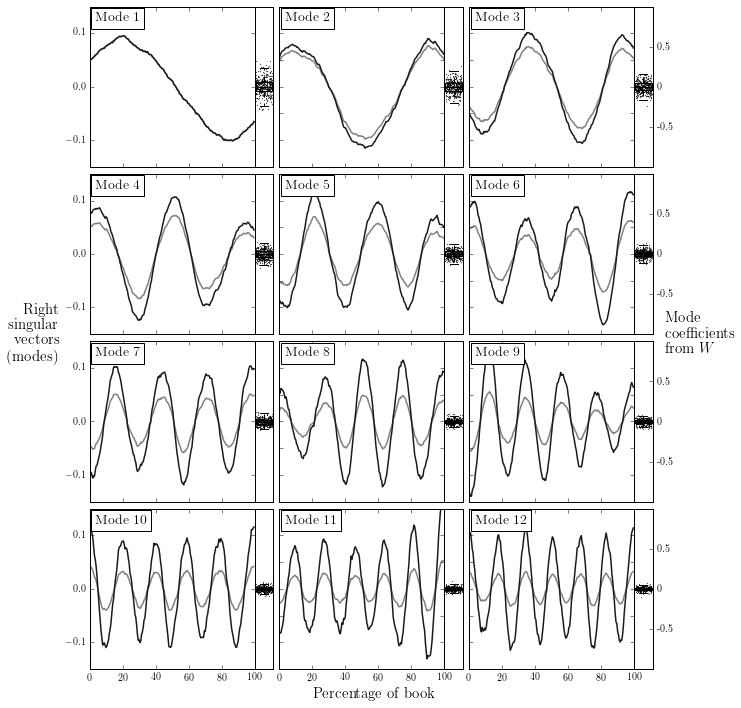

In [10]:
print(S[0])
num_x = 3
num_y = 12/num_x
xspacing = .01
yspacing = .01
xoffset = .07
yoffset = .07
xwidth = (1.-xoffset)/(num_x)-xspacing
yheight = (1.-yoffset)/(num_y)-yspacing
print('xwidth is {0}'.format(xwidth))
print('yheight is {0}'.format(yheight))
ylim = .15

fig = plt.figure(figsize=(8.5,10))
for i in range(12):
#         print(i)
#         print("====")
#         print((i-i%num_x))
    # ind = np.argsort(w[:,sv+svstart])[-20:]
    ax1rect = [xoffset+(i%num_x)*(xspacing+xwidth),1.-yheight-yspacing-(int(np.floor((i-i%num_x)/num_x))*(yspacing+yheight)),xwidth*.9,yheight]
    ax2rect = ax1rect.copy()
    ax2rect[0] += ax1rect[2]
    ax2rect[2] = (1-.9)*xwidth
    ax1 = fig.add_axes(ax1rect)
    ax2 = fig.add_axes(ax2rect)
    ax2.set_ylim([-1,1])
    ax2.set_xlim([.5,1.5])
    w_subset = np.random.choice(w_normalized[:,i],400)
    x_values = .55+.9*np.random.rand(400)
    ax2.scatter(x_values,
                w_subset,
                facecolor="k",
                edgecolor=None,
                linewidth=0.0,
                s=3.5,
                # edgewidth=0.0,
                alpha=0.1)
    ax2.scatter(x_values,
                w_subset,
                facecolor="k",
                edgecolor=None,
                linewidth=0.0,
                s=.7,
                # edgewidth=0.0,
                alpha=0.7)
#     p = [np.percentile(w_normalized[:,i],50),
#          np.percentile(w_normalized[:,i],50),
#          np.percentile(w_normalized[:,i],50)]
    boxprops = dict(linestyle='-', linewidth=1.0, color='k')
    medianprops = dict(linestyle='--', linewidth=1.0, color='k')
    # meanlineprops = dict(linestyle='--', linewidth=2.5, color='purple')
    ax2.boxplot(w_normalized[:,i],
               showfliers=False,
               boxprops=boxprops,
               medianprops=boxprops,
               whiskerprops=medianprops,
               widths=.9)
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_xticklabels([])
    ax2.set_yticklabels([])
    # plt.subplot(4,3,i+1)
    ax1.plot(np.arange(0,100,0.5),V[i,:]*S[i]/S[0],color=".5",linewidth=1.5)
    ax1.plot(np.arange(0,100,0.5),V[i,:],color=".1",linewidth=1.5)
    ax1.set_ylim([-ylim,ylim])
    if not i%num_x == 0:
        ax1.set_yticklabels([])
    if i%num_x == (num_x-1):
        ax2.yaxis.tick_right()
        ax2.set_yticks([-.5,0,.5])
        ax2.set_yticklabels([-.5,0,.5])
#         if int(np.floor((i-i%num_x)/num_x)) == num_y-1:
#             ax1.set_xticks([25,50,75])
    if not int(np.floor((i-i%num_x)/num_x)) == num_y-1:
        ax1.set_xticklabels([])
#         if int(np.floor((i-i%num_x)/num_x)) == num_y-1 and i%num_x == 1:
#             ax1.set_xlabel("Time")
#         if i == 0:
#             new_ticks = [x for x in ax1.yaxis.get_ticklocs()]
#             ax1.set_yticks(new_ticks)
#             new_ticklabels = [str(x) for x in new_ticks]
#             new_ticklabels[-1] = "Happs"
#             # ax1.set_yticklabels(new_ticklabels)
    props = dict(boxstyle='square', facecolor='white', alpha=1.0)
    # fig.text(ax1rect[0]+.03/xwidth, ax1rect[1]+ax1rect[3]-.03/yheight, letters[i],
    my_ylim = ax1.get_ylim()
    # my_ylim = [-ylim,ylim]
    ax1.text(.035*100, my_ylim[0]+.965*(my_ylim[1]-my_ylim[0]), "Mode {0}".format(i+1),
                 fontsize=14,
                 verticalalignment='top',
                 horizontalalignment='left',
                 bbox=props)
    if i%num_x == 0:
        # new_ticks = [x for x in ax1.yaxis.get_ticklocs()]
        # ax1.set_yticks(new_ticks[:-2])
        ax1.set_yticks([-.1,0,.1])
        
fig.text((1.-xoffset)/2.+xoffset,yoffset/2.,"Percentage of book",verticalalignment='center', horizontalalignment='center',fontsize=15) #,horizontalalign="center")    
# plt.subplot(4,3,2)
# fig.text(0,(1.-yoffset)/2.+yoffset,r"Mode space $h_{\textnormal{avg}}$",verticalalignment='center', horizontalalignment='center',fontsize=15,rotation=90) #,horizontalalign="center"
# fig.text(1.05,(1.-yoffset)/2.+yoffset,r"Within-book normalized mode coefficients",verticalalignment='center', horizontalalignment='center',fontsize=15,rotation=-90) #,horizontalalign="center"
# fig.text(0.02,(1.-yoffset)/2.+yoffset,r"""Mode
# space
# $h_{\textnormal{avg}}$""",verticalalignment='center', horizontalalignment="right",fontsize=15,rotation=0) #,horizontalalign="center"
fig.text(0.02,(1.-yoffset)/2.+yoffset,r"""Right
singular
vectors
(modes)""",verticalalignment='center', horizontalalignment="right",fontsize=15,rotation=0) #,horizontalalign="center"
fig.text(1.01,(1.-yoffset)/2.+yoffset,"""Mode
coefficients
from $W$""",verticalalignment='center', horizontalalignment='left',fontsize=15,rotation=0) #,horizontalalign="center"

mysavefig("SVD-timeseries-unweighted-mean0.pdf",folder="media/figures/SVD/salads",openfig=True)

## Note:

Not a simple story here about each of these timeseries are explained by the modes.

They each have effectively a coefficient for the mode,
and so to show the stories and the mode on the same plot,
it really only makes sense to do so one at a time.

For each book, I can put the coefficients on each mode and show those modes.
But, if I show a bunch of different books, they all have different coefficients.
*I could try to normalize each book timeseries by it's energy...*

Here is a look at the reconstruction of a single book:

The Declaration of Independence of the United States of America


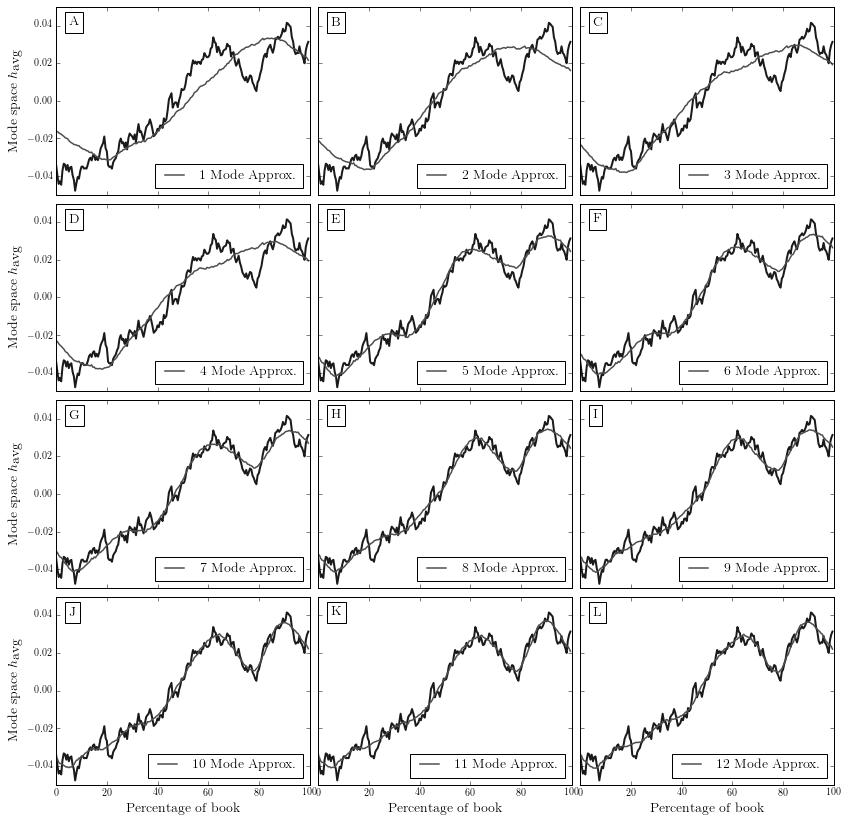

In [11]:
fig = plt.figure(figsize=(12,12))
# plt.title('12 mode reconstruction of {}'.format(b.title[:30]))

n_x = 3
n_y = 4

# whole figure label padding
xpad = .085
ypad = .085
xpadr = .015
ypadr = .015
xpadding= .01
ypadding = .01
# remaining width
xrem = 1.-xpad-xpadr
yrem = 1.-ypad-ypadr
xwidth = (xrem-(n_x-1)*xpadding)/(n_x)
ywidth = (yrem-(n_y-1)*ypadding)/(n_y)

# for i in range(istart,plotsize+1):

# b,s,i = mode_0_top_pos_norm[0]
i = 0
b = q[i]
print(b.title)
                
for k in range(1,13):
    # this is the y
    n = int(np.floor(((k-1)/n_x)))
    # this is the x
    m = (k-1)-n*n_x
    # print(m,n)
    rect = [xpad+m*(xwidth+xpadding),1-ywidth-ypadr-n*(ywidth+ypadding),xwidth,ywidth]
    ax = fig.add_axes(rect)  
    # plt.title('{} mode reconstruction of {}'.format(k,b.title[:30]))
    
    ax.plot(np.arange(0,100,0.5),big_matrix_mean0[i],color=".1",linewidth=2,label=None)
    # print(s,i,b.title)
    reconstruction = np.zeros(V[0,:].shape)
    for j in range(0,k):
        reconstruction += V[j,:]*w[i,j]
    ax.plot(np.arange(0,100,0.5),reconstruction,color=".3",linewidth=1.5,label="{0} Mode Approx.".format(k))
    if m != 0:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel(r"Mode space $h_{\textnormal{avg}}$",fontsize=14)
    if n != (n_y-1):
        # print("no xlabel")
        ax.set_xticklabels([])
    else: 
        ax.set_xlabel("Percentage of book",fontsize=14)
    props = dict(boxstyle='square', facecolor='white', alpha=1.0)
    # fig.text(ax1rect[0]+.03/xwidth, ax1rect[1]+ax1rect[3]-.03/yheight, letters[i],
    my_ylim = ax.get_ylim()
    # ax.text(.035*100, my_ylim[0]+.965*(my_ylim[1]-my_ylim[0]), letters[k-1],
    ax.text(0.05, 0.95, letters[k-1],
                 fontsize=14,
                 verticalalignment='top',
                 horizontalalignment='left',
                 transform=ax.transAxes,
                 bbox=props)
    # ax.text(.05,.95,"A")
    ax.legend(loc="lower right",fontsize=14)
# plt.subplot(4,3,2)
# plt.title('12 mode reconstruction of {}'.format(b.title[:31]),fontsize=20)
mysavefig("example-timeseries-recon-stacked-{}.pdf".format(b.gutenberg_id),folder="media/figures/SVD/salads",openfig=False)

## could put these all on the same plot (by flipping them....but the sign matters here!)

again this seems to be an issue with the SVD though.

it is finding the modes that explain the most variance using BOTH versions of the mode

...which is not what we want!! ex: man in the whole is the main story.

it will struggle to find this because it will need to explain with the negative of this!

In [12]:
num_modes = 10

core_emotional_arcs = [sorted(zip(w_normalized[i,:],
                                  range(1,len(w_normalized[i,:])+1)),
                              key=lambda x: np.abs(x[0]),
                              reverse=True) for i,b in enumerate(q)]

pos_stories = [[] for i in range(len(core_emotional_arcs[0]))]
neg_stories = [[] for i in range(len(core_emotional_arcs[0]))]

for i in range(len(core_emotional_arcs)):
    if core_emotional_arcs[i][0][0] > 0:
        pos_stories[core_emotional_arcs[i][0][1]-1].append(i)
    else:
        neg_stories[core_emotional_arcs[i][0][1]-1].append(i)

# check that these types work
m=0
w_normalized[pos_stories[m],m]
# print(pos_stories[0])
# print(len(q))

all_lists = [{} for i in range(num_modes)]

for m in range(num_modes):
    all_lists[m]["top_abs"] = sorted(zip(q,w[:,m],range(len(q))),key=lambda x: np.abs(x[1]),reverse=True)
    all_lists[m]["top_pos"] = sorted(zip(q,w[:,m],range(len(q))),key=lambda x: -x[1])
    all_lists[m]["top_neg"] = sorted(zip(q,w[:,m],range(len(q))),key=lambda x: x[1])
    all_lists[m]["top_abs_norm"] = sorted(zip(q,w_normalized[:,m],range(len(q))),key=lambda x: np.abs(x[1]),reverse=True)
    all_lists[m]["top_pos_norm"] = sorted(zip(q,w_normalized[:,m],range(len(q))),key=lambda x: -x[1])
    all_lists[m]["top_neg_norm"] = sorted(zip(q,w_normalized[:,m],range(len(q))),key=lambda x: x[1])
    q_mode = [q[i] for i in pos_stories[m]]
    all_lists[m]["top_pos_norm_attached"] = sorted(zip(q_mode,
                                                       w_normalized[pos_stories[m],m],
                                                       pos_stories[m]),
                                                   key=lambda x: x[1],
                                                   reverse=True)
    all_lists[m]["top_pos_norm_attached_downloads"] = sorted(zip(q_mode,
                                                                 w_normalized[pos_stories[m],m],
                                                                 pos_stories[m]),
                                                             key=lambda x: x[0].downloads,
                                                             reverse=True)
    q_mode = [q[i] for i in neg_stories[m]]
    all_lists[m]["top_neg_norm_attached"] = sorted(zip(q_mode,
                                                       w_normalized[neg_stories[m],m],
                                                       neg_stories[m]),
                                                   key=lambda x: x[1])
    all_lists[m]["top_neg_norm_attached_downloads"] = sorted(zip(q_mode,
                                                                 w_normalized[neg_stories[m],m],
                                                                 neg_stories[m]),
                                                             key=lambda x: x[0].downloads,
                                                             reverse=True)                                                        

xwidth is 0.29
0
[-0.20000000000000001, -0.15000000000000002, -0.10000000000000001, -0.049999999999999989, 0.0, 0.049999999999999989, 0.10000000000000003, 0.15000000000000002, 0.20000000000000001, 0.25]
1
2
xwidth is 0.29
0
[-0.20000000000000001, -0.15000000000000002, -0.10000000000000001, -0.049999999999999989, 0.0, 0.049999999999999989, 0.10000000000000003, 0.15000000000000002, 0.20000000000000001, 0.25]
1
2
xwidth is 0.29
0
[-0.40000000000000002, -0.30000000000000004, -0.20000000000000001, -0.099999999999999978, 0.0, 0.099999999999999978, 0.20000000000000007, 0.30000000000000004, 0.40000000000000002, 0.5]
1
2
xwidth is 0.29
0
[-0.40000000000000002, -0.30000000000000004, -0.20000000000000001, -0.099999999999999978, 0.0, 0.099999999999999978, 0.20000000000000007, 0.30000000000000004, 0.40000000000000002, 0.5]
1
2


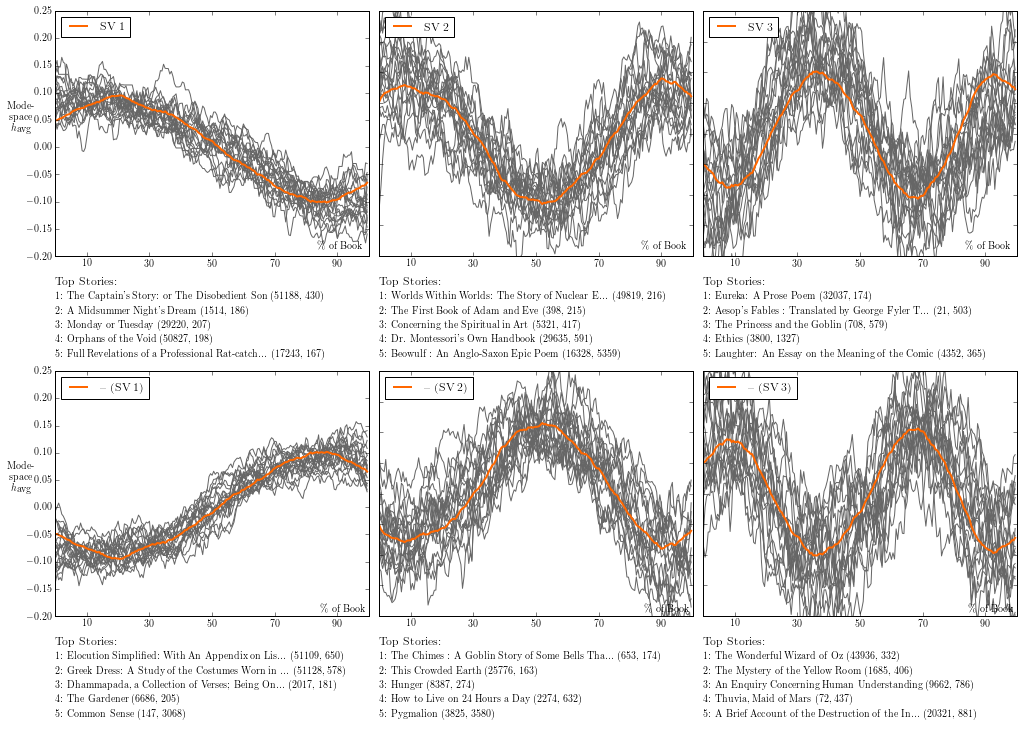

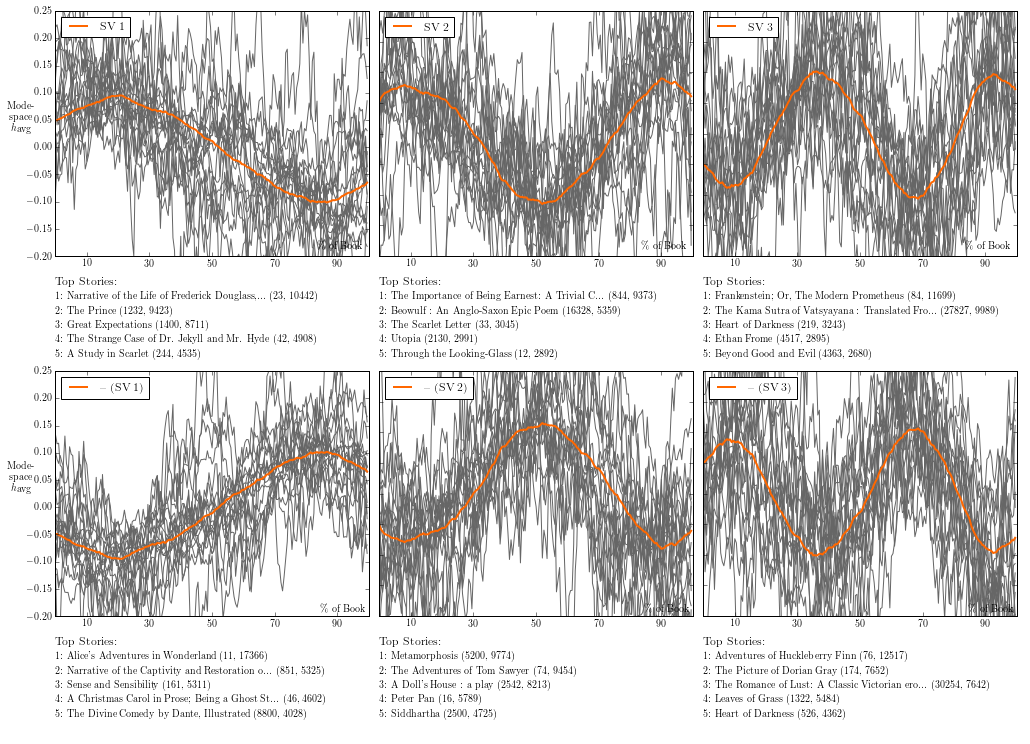

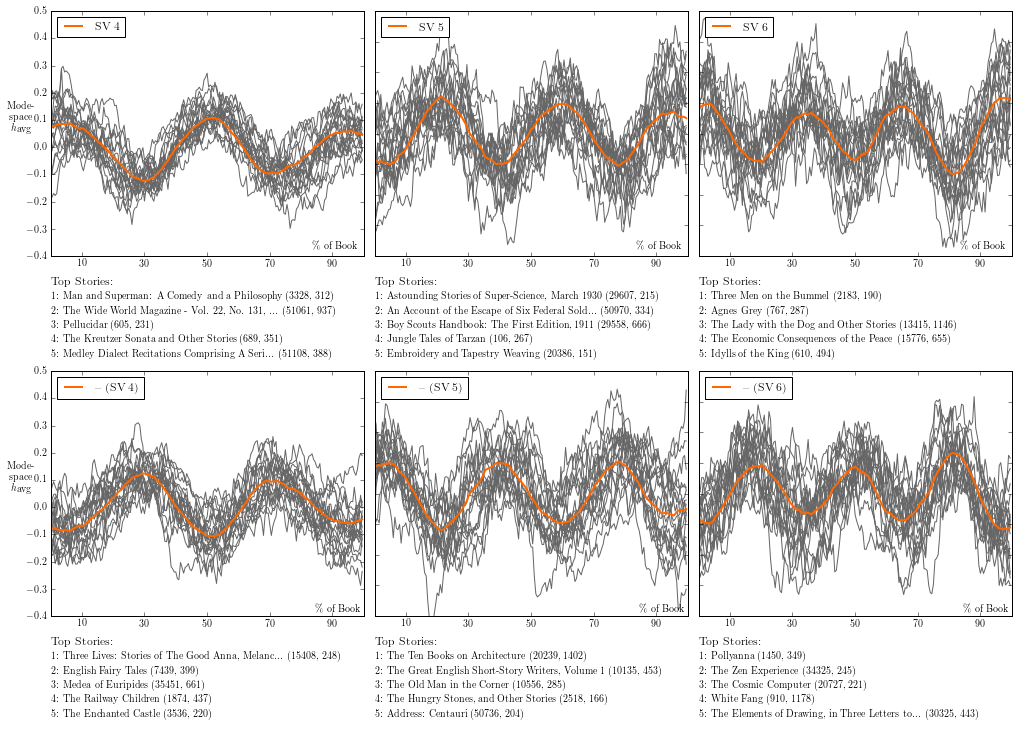

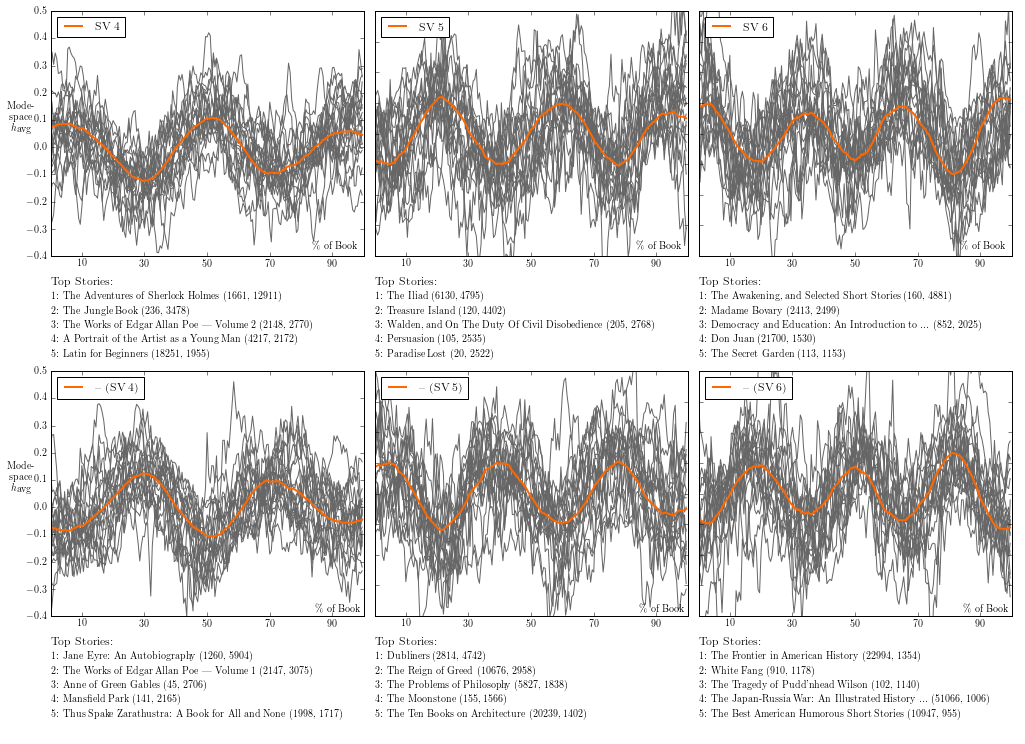

In [13]:
def plot_svs(svstart,v=True,fix_ylim=0.0,xspacing=.01,keys=["top_pos_norm","top_neg_norm"]):
    nsvs = 3
    xoffset = .1
    xwidth = (1.-xoffset)/(nsvs)-xspacing
    print('xwidth is {0}'.format(xwidth))
    
    chars = 47
    
    fig = plt.figure(figsize=(15,10))
    for sv in range(0,3):
        print(sv)
        # ind = np.argsort(w[:,sv+svstart])[-20:]
        ax1rect = [xoffset+sv*(xspacing+xwidth),.65,xwidth,.34]
        ax1 = fig.add_axes(ax1rect)
        ax1books = fig.add_axes([xoffset+sv*(xspacing+xwidth),.5,xwidth,.1])
        # ax1books.text?
        # ax.set_title('20 closest positive correlates')
        if v:
            print('-'*80)
            print('20 closest positive correlates:')
        j=0
        for b,s,i in all_lists[sv+svstart][keys[0]][:20]:
            ax1.plot(np.arange(0,100,0.5),big_matrix_mean0[i]/w[i,sv+svstart],color=".4",label=None)
            # plt.plot(big_matrix_mean0[i],color=".4")
            if v:
                print(s,b.title)
            if j<5 and not b.exclude:
                if len(b.title) > chars:
                    # ax1books.text(0.0,.9-j*.2,'\\href{{http://gutenberg.org/ebooks/{2}}}{{{0}: {1}... ({2}, {3})}}'.format(j+1,b.title[:chars-3].replace("\n",": "),b.gutenberg_id,b.downloads),fontsize=10)
                    ax1books.text(0.0,.9-j*.2,'{0}: {1}... ({2}, {3})'.format(j+1,b.title[:chars-3].replace("\n",": "),b.gutenberg_id,b.downloads),fontsize=10)
                else:
                    ax1books.text(0.0,.9-j*.2,'{0}: {1} ({2}, {3})'.format(j+1,b.title.replace("\n",": "),b.gutenberg_id,b.downloads),fontsize=10)
                    # ax1books.text(0.0,.9-j*.2,'{0}: {1} ({2}, {3})'.format(j+1,b.title.replace("\n",": "),b.gutenberg_id,b.downloads),fontsize=10)
                j+=1
            # print(b.exclude)
        ax1.plot(np.arange(0,100,0.5),V[sv+svstart,:],color="#ff6700",linewidth=2,label="SV {}".format(sv+svstart+1))
        # ax1.set_xticklabels([])
        # ax1.set_xticklabels(["0","20","40","60",r"\% of Book",""])
        ax1.set_xticks([10,30,50,70,90])
        ax1.set_xticklabels(["10","30","50","70","90"])
        # ax1.set_xlabel(r"Top stories:~~~~~ ~~~~~ ~~~~~ ~~~~~ ~~~~~ ~~~~~ ~~~~~  ~~~~~ {\normalsize Percentage of book}")
        # ax1.set_xlabel(r"Top stories:~~~~~ ~~~~~ ~~~~~ ~~~~~ ~~~~~ ~~~~~ ~~~~~  ~~~~~ ~~~~~ ~~~~~")
        ax1.text(.98,0.02,r"\% of Book",ha="right",va="bottom",transform=ax1.transAxes)
        ax1books.text(0.0,1.1,"Top Stories:",fontsize=12)
        ax1.legend(loc="upper left")

        #ax1.axis('off')
        ax1books.axis('off')

        ax2 = fig.add_axes([xoffset+sv*(xspacing+xwidth),.15,xwidth,.34])
        ax2books = fig.add_axes([xoffset+sv*(xspacing+xwidth),.0,xwidth,.10])
        # ax2.set_title('20 closest negative correlates')
        if v:
            print('-'*80)
            print('20 closest negative correlates:')
        j=0
        for b,s,i in all_lists[sv+svstart][keys[1]][:20]:
            ax2.plot(np.arange(0,100,0.5),-big_matrix_mean0[i]/np.sum(np.abs(w[i,:]))/s,color=".4",label=None)
            # plt.plot(big_matrix_mean0[i],color=".4")
            if v:
                print(s,b.title)
            if j<5 and not b.exclude:
                if len(b.title) > chars:
                    ax2books.text(0.0,.9-j*.2,'{0}: {1}... ({2}, {3})'.format(j+1,b.title[:chars-3].replace("\n",": "),b.gutenberg_id,b.downloads),fontsize=10)
                else:
                    ax2books.text(0.0,.9-j*.2,'{0}: {1} ({2}, {3})'.format(j+1,b.title.replace("\n",": "),b.gutenberg_id,b.downloads),fontsize=10)
                j+=1
            # print(b.exclude)
        ax2.plot(np.arange(0,100,0.5),-V[sv+svstart,:],color="#ff6700",linewidth=2,label="-- (SV {})".format(sv+svstart+1))
        # ax2.set_xticklabels([])
        # ax2.set_xlabel(r"Top stories:~~~~~ ~~~~~ ~~~~~ ~~~~~ ~~~~~ ~~~~~ ~~~~~ ~~~~~ {\normalsize Percentage of book}")
        ax2.legend(loc="upper left")
        
        # ax2.set_xticklabels(["0","20","40","60",r"\% of Book",""])
        # ax2.set_xticklabels(["0","20","40","60","",""])
        ax2books.text(0.0,1.1,"Top Stories:",fontsize=12)
        
        ax2.set_xticks([10,30,50,70,90])
        ax2.set_xticklabels(["10","30","50","70","90"])
        ax2.text(.99,0.01,r"\% of Book",ha="right",va="bottom",transform=ax2.transAxes)
        
        
        #ax1.axis('off')
        ax2books.axis('off')
        
        if fix_ylim > 0:
            ax1.set_ylim([-fix_ylim,fix_ylim])
            ax2.set_ylim([-fix_ylim,fix_ylim])
        if sv > 0:
            ax1.set_yticklabels([])
            ax2.set_yticklabels([])
        else:
            new_ticks = [x for x in ax1.yaxis.get_ticklocs()]
            ax1.set_yticks(new_ticks)
            ax2.set_yticks(new_ticks)
            print(new_ticks)
            # new_ticks[new_ticks.index(0.0)] = "Happs"
            new_ticks[new_ticks.index(0.0)] = r"""Mode-
space
$h_{\textnormal{avg}}$"""
            
            # ax1.set_yticklabels(new_ticks)
            # ax2.set_yticklabels(new_ticks)
            ax1.set_ylabel(r"""Mode-
space
$h_{\textnormal{avg}}$""",rotation=0)
            ax2.set_ylabel(r"""Mode-
space
$h_{\textnormal{avg}}$""",rotation=0)
            
            
    # mysavefig('SV{0}.svg'.format('4-6'))
    # mysavefig("SVD-timeseries-mode-{}-{}.png".format(svstart+1,svstart+4),folder="media/figures/SVD",openfig=False)
    mysavefig("SVD-timeseries-mode-{}-{}.pdf".format(svstart+1,svstart+4),folder="media/figures/SVD/salads",openfig=True)
plot_svs(0,v=False,fix_ylim=.2,keys=["top_pos_norm_attached","top_neg_norm_attached"])
plot_svs(0,v=False,fix_ylim=.2,keys=["top_pos_norm_attached_downloads","top_neg_norm_attached_downloads"])
plot_svs(3,v=False,fix_ylim=.4,keys=["top_pos_norm_attached","top_neg_norm_attached"])
plot_svs(3,v=False,fix_ylim=.4,keys=["top_pos_norm_attached_downloads","top_neg_norm_attached_downloads"])

the previous analysis took the stories which are closest to the core emotional arcs

but, a story could have been the closest to two different arcs (although very unlikely) with
coefficients that are large for two modes, and 0 for the rest.



so, we need to actually figure out the main core emotional arc for each story

do this by considering the absolute value of the coeff, but keep track of whether it was pos or neg



1 for SV 1, and -1 for -SV 1.

2 for SV 2, and -2 for -SV 2.

In [14]:
core_emotional_arcs = [sorted(zip(w_normalized[i,:],
                                  range(1,len(w_normalized[i,:])+1)),
                              key=lambda x: np.abs(x[0]),
                              reverse=True) for i,b in enumerate(q)]

In [15]:
def core_stats(book_indices):
    N = len(book_indices)
    percentage = N/len(q)*100
    these_downloads = [q[i].downloads for i in book_indices]
    percentage_more = np.sum(these_downloads>np.mean(all_downloads))/len(these_downloads)*100
    return N,percentage,np.mean(these_downloads),np.median(these_downloads),these_downloads,np.var(these_downloads),percentage_more

In [16]:
for i in range(15):
    stats = core_stats(pos_stories[i])
    print("SV {}".format(i+1),stats[:4])
    fig = plt.figure(figsize=(6,.55))
    ax = fig.add_axes([0,0,1,1])
    # ax.set_xlim([100,1000])
    # ax.hist(stats[4],bins=np.arange(100,20000,100),color=".5")
    # ax.hist(stats[4],color=".5")
    a = ax.hist(np.log10(stats[4]),bins=np.arange(2.0,4.5,.07),color=".5")
    ax.plot([2.0,4.5],[0.0,0.0],linewidth=0.5,color=".7")
    ax.set_xlim([2.0,4.5])
    y_range = ax.get_ylim()[1]
    ax.plot(np.log10(stats[3]),a[0][find_bin_i(a[1],np.log10(stats[3]))]+y_range*.17,'kv',markersize=13)
    ax.plot(np.log10(stats[2]),a[0][find_bin_i(a[1],np.log10(stats[2]))]+y_range*.17,'kv',markersize=13,fillstyle='none')
    # ax.set_xlim([100,20000])
    ax.axis("off")
    mysavefig("SV{0}-+-sparkhist.pdf".format(i+1),folder="media/figures/SVD/salads/",date=False,openfig=False)
    call("pdfcrop media/figures/SVD/salads/SV{0}-+-sparkhist.pdf".format(i+1),shell=True)
    call("mv media/figures/SVD/salads/SV{0}-+-sparkhist{{-crop,}}.pdf".format(i+1),shell=True)
    plt.close(fig)
    fig = plt.figure(figsize=(1.5,.55))
    ax = fig.add_axes([0,0,1,1])
    ax.plot(np.arange(0,100,0.5),V[i,:],color="#ff6700",linewidth=2)
    ax.axis("off")
    mysavefig("SV{0}-+-spark.pdf".format(i+1),folder="media/figures/SVD/salads/",date=False,openfig=False)
    call("pdfcrop media/figures/SVD/salads/SV{0}-+-spark.pdf".format(i+1),shell=True)
    call("mv media/figures/SVD/salads/SV{0}-+-spark{{-crop,}}.pdf".format(i+1),shell=True)
    plt.close(fig)
    stats = core_stats(neg_stories[i])
    print("-SV {}".format(i+1),stats[:4])
    fig = plt.figure(figsize=(6,.55))
    ax = fig.add_axes([0,0,1,1])
    a = ax.hist(np.log10(stats[4]),bins=np.arange(2.0,4.5,.07),color=".5")
    ax.plot([2.0,4.5],[0.0,0.0],linewidth=0.5,color=".7")
    ax.set_xlim([2.0,4.5])
    y_range = ax.get_ylim()[1]
    ax.plot(np.log10(stats[3]),a[0][find_bin_i(a[1],np.log10(stats[3]))]+y_range*.17,'kv',markersize=13)
    ax.plot(np.log10(stats[2]),a[0][find_bin_i(a[1],np.log10(stats[2]))]+y_range*.17,'kv',markersize=13,fillstyle='none')
    ax.axis("off")
    mysavefig("SV{0}---sparkhist.pdf".format(i+1),folder="media/figures/SVD/salads/",date=False,openfig=False)
    call("pdfcrop media/figures/SVD/salads/SV{0}---sparkhist.pdf".format(i+1),shell=True)
    call("mv media/figures/SVD/salads/SV{0}---sparkhist{{-crop,}}.pdf".format(i+1),shell=True)
    plt.close(fig)
    fig = plt.figure(figsize=(1.5,.55))
    ax = fig.add_axes([0,0,1,1])
    ax.plot(np.arange(0,100,0.5),-V[i,:],color="#ff6700",linewidth=2)
    ax.axis("off")
    mysavefig("SV{0}---spark.pdf".format(i+1),folder="media/figures/SVD/salads/",date=False,openfig=False)
    call("pdfcrop media/figures/SVD/salads/SV{0}---spark.pdf".format(i+1),shell=True)
    call("mv media/figures/SVD/salads/SV{0}---spark{{-crop,}}.pdf".format(i+1),shell=True)
    plt.close(fig)

NameError: name 'all_downloads' is not defined

In [ ]:
f = open("media/figures/SVD/salads/SVD-table-point5.tex","w")
f.write(r"\begin{tabular}{c | c | c | c | c | c | c | c | c}")
f.write("\n")
f.write(r"Mode & Mode Arc & $N_m$ & $N_m/N$ & DL Median $\blacktriangledown$ & DL Mean $\triangledown$ & DL Variance & \% $>$ Average & Download Distribution \\")
f.write("\n")
f.write(r"\hline")
# f.write("\n")
# f.write(r"\hline")
f.write("\n")
for i in range(10):
    stats = core_stats(pos_stories[i])
    if stats[1] > .5:
        print("SV {}".format(i+1),stats[:4])
        f.write(r"SV {0} & \adjustimage{{height=12px,width=45px,valign=m}}{{SV{0}-+-spark.pdf}} & {1} & {2:.1f}\%".format(i+1,stats[0],stats[1]))
        f.write(r" & {2:.1f} & {1:.1f} & {3:.0f} & {4:.1f}\%".format(i+1,stats[2],stats[3],stats[5],stats[6]))
        f.write(r" & \adjustimage{{height=13px,width=110px,valign=m}}{{SV{0}-+-sparkhist.pdf}} \\".format(i+1))
        f.write("\n")
    stats = core_stats(neg_stories[i])
    if stats[1] > .5:
        print("-SV {}".format(i+1),stats[:4])
        f.write(r"-SV {0} & \adjustimage{{height=12px,width=45px,valign=m}}{{SV{0}---spark.pdf}} & {1} & {2:.1f}\%".format(i+1,stats[0],stats[1]))
        f.write(r" & {2:.1f} & {1:.1f} & {3:.0f} & {4:.1f}\%".format(i+1,stats[2],stats[3],stats[5],stats[6]))
        f.write(r" & \adjustimage{{height=13px,width=110px,valign=m}}{{SV{0}---sparkhist.pdf}} \\".format(i+1))
        f.write("\n")
f.write(r"\end{tabular}")
f.close()
f = open("media/figures/SVD/salads/tmp.tex","w")
f.write(r"\input{SVD-table-point5}")
f.write("\n")
f.close()
call("pdflatex table-wrapper",shell=True,cwd="/Users/andyreagan/projects/2014/09-books/media/figures/SVD/salads")
call("pdfcrop media/figures/SVD/salads/table-wrapper.pdf",shell=True)
call("mv media/figures/SVD/salads/table-wrapper-crop.pdf media/figures/SVD/salads/SVD-table-point5.pdf",shell=True)
call("open media/figures/SVD/salads/SVD-table-point5.pdf",shell=True)

f = open("media/figures/SVD/salads/SVD-table-2point5.tex","w")
f.write(r"\begin{tabular}{c | c | c | c | c | c | c | c | c}")
f.write("\n")
f.write(r"Mode & Mode Arc & $N_m$ & $N_m/N$ & DL Median $\blacktriangledown$ & DL Mean $\triangledown$ & DL Variance & \% $>$ Average & Download Distribution \\")
f.write("\n")
f.write(r"\hline")
# f.write("\n")
# f.write(r"\hline")
f.write("\n")
for i in range(10):
    stats = core_stats(pos_stories[i])
    if stats[1] > 2.5:
        print("SV {}".format(i+1),stats[:4])
        f.write(r"SV {0} & \adjustimage{{height=12px,width=45px,valign=m}}{{SV{0}-+-spark.pdf}} & {1} & {2:.1f}\%".format(i+1,stats[0],stats[1]))
        f.write(r" & {2:.1f} & {1:.1f} & {3:.0f} & {4:.1f}\%".format(i+1,stats[2],stats[3],stats[5],stats[6]))
        f.write(r" & \adjustimage{{height=13px,width=110px,valign=m}}{{SV{0}-+-sparkhist.pdf}} \\".format(i+1))
        f.write("\n")
    stats = core_stats(neg_stories[i])
    if stats[1] > 2.5:
        print("-SV {}".format(i+1),stats[:4])
        f.write(r"-SV {0} & \adjustimage{{height=12px,width=45px,valign=m}}{{SV{0}---spark.pdf}} & {1} & {2:.1f}\%".format(i+1,stats[0],stats[1]))
        f.write(r" & {2:.1f} & {1:.1f} & {3:.0f} & {4:.1f}\%".format(i+1,stats[2],stats[3],stats[5],stats[6]))
        f.write(r" & \adjustimage{{height=13px,width=110px,valign=m}}{{SV{0}---sparkhist.pdf}} \\".format(i+1))
        f.write("\n")
f.write(r"\end{tabular}")
f.close()
f = open("media/figures/SVD/salads/tmp.tex","w")
f.write(r"\input{SVD-table-2point5}")
f.write("\n")
f.close()
call("pdflatex table-wrapper",shell=True,cwd="/Users/andyreagan/projects/2014/09-books/media/figures/SVD/salads")
call("pdfcrop media/figures/SVD/salads/table-wrapper.pdf",shell=True)
call("mv media/figures/SVD/salads/table-wrapper-crop.pdf media/figures/SVD/salads/SVD-table-2point5.pdf",shell=True)
call("open media/figures/SVD/salads/SVD-table-2point5.pdf",shell=True)

In [ ]:
def plot_svs_links(svstart,v=True,fix_ylim=0.0,xspacing=.01,keys=["top_pos_norm","top_neg_norm"]):
    nsvs = 3
    xoffset = .1
    xwidth = (1.-xoffset)/(nsvs)-xspacing
    print('xwidth is {0}'.format(xwidth))
    
    chars = 40
    lineheight = .10
    
    fig = plt.figure(figsize=(13,10))
    for sv in range(0,3):
        print(sv)
        # ind = np.argsort(w[:,sv+svstart])[-20:]
        ax1rect = [xoffset+sv*(xspacing+xwidth),.72,xwidth,.27]
        ax1 = fig.add_axes(ax1rect)
        ax1books = fig.add_axes([xoffset+sv*(xspacing+xwidth),.5,xwidth,.17])
        # ax1books.text?
        # ax.set_title('20 closest positive correlates')
        if v:
            print('-'*80)
            print('20 closest positive correlates:')
        j=0
        for b,s,i in all_lists[sv+svstart][keys[0]][:20]:
            ax1.plot(np.arange(0,100,0.5),big_matrix_mean0[i]/np.sum(np.abs(w[i,:]))/s,color=".4",label=None)
            # plt.plot(big_matrix_mean0[i],color=".4")
            if v:
                print(s,b.title)
            if j<5 and not b.exclude:
                if len(b.title) > chars:
                    # ax1books.text(0.0,.9-j*.2,'\\href{{http://gutenberg.org/ebooks/{2}}}{{{0}: {1}... ({2}, {3})}}'.format(j+1,b.title[:chars-3].replace("\n",": "),b.gutenberg_id,b.downloads),fontsize=10)
                    ax1books.text(0.0,.97-(2*j)*lineheight,'{0}: {1}... ({2}, {3})'.format(j+1,b.title[:chars-3].replace("\n",": "),b.gutenberg_id,b.downloads),fontsize=10)
                    ax1books.text(0.0,.97-(2*j+.9)*lineheight,r'\url{{http://hedonometer.org/books/v3/{0}/}}'.format(b.gutenberg_id),fontsize=10)
                else:
                    ax1books.text(0.0,.97-(2*j)*lineheight,'{0}: {1} ({2}, {3})'.format(j+1,b.title.replace("\n",": "),b.gutenberg_id,b.downloads),fontsize=10)
                    ax1books.text(0.0,.97-(2*j+.9)*lineheight,r'\url{{http://hedonometer.org/books/v3/{0}/}}'.format(b.gutenberg_id),fontsize=10)
                    # ax1books.text(0.0,.9-j*.2,'{0}: {1} ({2}, {3})'.format(j+1,b.title.replace("\n",": "),b.gutenberg_id,b.downloads),fontsize=10)
                j+=1
            # print(b.exclude)
        ax1.plot(np.arange(0,100,0.5),V[sv+svstart,:],color="#ff6700",linewidth=2,label="SV {}".format(sv+svstart+1))
        # ax1.set_xticklabels([])
        # ax1.set_xticklabels(["0","20","40","60",r"\% of Book",""])
        ax1.set_xticks([10,30,50,70,90])
        ax1.set_xticklabels(["10","30","50","70","90"])
        # ax1.set_xlabel(r"Top stories:~~~~~ ~~~~~ ~~~~~ ~~~~~ ~~~~~ ~~~~~ ~~~~~  ~~~~~ {\normalsize Percentage of book}")
        # ax1.set_xlabel(r"Top stories:~~~~~ ~~~~~ ~~~~~ ~~~~~ ~~~~~ ~~~~~ ~~~~~  ~~~~~ ~~~~~ ~~~~~")
        ax1.text(.98,0.02,r"\% of Book",ha="right",va="bottom",transform=ax1.transAxes)
        ax1books.text(0.0,1.1,"Top Stories:",fontsize=12)
        ax1.legend(loc="upper left")

        #ax1.axis('off')
        ax1books.axis('off')

        ax2 = fig.add_axes([xoffset+sv*(xspacing+xwidth),.22,xwidth,.27])
        ax2books = fig.add_axes([xoffset+sv*(xspacing+xwidth),.0,xwidth,.17])
        # ax2.set_title('20 closest negative correlates')
        if v:
            print('-'*80)
            print('20 closest negative correlates:')
        j=0
        for b,s,i in all_lists[sv+svstart][keys[1]][:20]:
            ax2.plot(np.arange(0,100,0.5),-big_matrix_mean0[i]/np.sum(np.abs(w[i,:]))/s,color=".4",label=None)
            # plt.plot(big_matrix_mean0[i],color=".4")
            if v:
                print(s,b.title)
            if j<5 and not b.exclude:
                if len(b.title) > chars:
                    # ax1books.text(0.0,.9-j*.2,'\\href{{http://gutenberg.org/ebooks/{2}}}{{{0}: {1}... ({2}, {3})}}'.format(j+1,b.title[:chars-3].replace("\n",": "),b.gutenberg_id,b.downloads),fontsize=10)
                    ax2books.text(0.0,.95-(2*j)*lineheight,'{0}: {1}... ({2}, {3})'.format(j+1,b.title[:chars-3].replace("\n",": "),b.gutenberg_id,b.downloads),fontsize=10)
                    ax2books.text(0.0,.95-(2*j+.9)*lineheight,r'\url{{http://hedonometer.org/books/v3/{0}/}}'.format(b.gutenberg_id),fontsize=10)
                else:
                    ax2books.text(0.0,.95-(2*j)*lineheight,'{0}: {1} ({2}, {3})'.format(j+1,b.title.replace("\n",": "),b.gutenberg_id,b.downloads),fontsize=10)
                    ax2books.text(0.0,.95-(2*j+.9)*lineheight,r'\url{{http://hedonometer.org/books/v3/{0}/}}'.format(b.gutenberg_id),fontsize=10)
                    # ax1books.text(0.0,.9-j*.2,'{0}: {1} ({2}, {3})'.format(j+1,b.title.replace("\n",": "),b.gutenberg_id,b.downloads),fontsize=10)
                j+=1
            # print(b.exclude)
        ax2.plot(np.arange(0,100,0.5),-V[sv+svstart,:],color="#ff6700",linewidth=2,label="-- (SV {})".format(sv+svstart+1))
        # ax2.set_xticklabels([])
        # ax2.set_xlabel(r"Top stories:~~~~~ ~~~~~ ~~~~~ ~~~~~ ~~~~~ ~~~~~ ~~~~~ ~~~~~ {\normalsize Percentage of book}")
        ax2.legend(loc="upper left")
        
        # ax2.set_xticklabels(["0","20","40","60",r"\% of Book",""])
        # ax2.set_xticklabels(["0","20","40","60","",""])
        ax2books.text(0.0,1.1,"Top Stories:",fontsize=12)
        
        ax2.set_xticks([10,30,50,70,90])
        ax2.set_xticklabels(["10","30","50","70","90"])
        ax2.text(.99,0.01,r"\% of Book",ha="right",va="bottom",transform=ax2.transAxes)
        
        
        #ax1.axis('off')
        ax2books.axis('off')
        
        if fix_ylim > 0:
            ax1.set_ylim([-fix_ylim,fix_ylim])
            ax2.set_ylim([-fix_ylim,fix_ylim])
        if sv > 0:
            ax1.set_yticklabels([])
            ax2.set_yticklabels([])
        else:
            new_ticks = [x for x in ax1.yaxis.get_ticklocs()]
            ax1.set_yticks(new_ticks)
            ax2.set_yticks(new_ticks)
            print(new_ticks)
            # new_ticks[new_ticks.index(0.0)] = "Happs"
            new_ticks[new_ticks.index(0.0)] = r"""Mode-
space
$h_{\textnormal{avg}}$"""
            
            # ax1.set_yticklabels(new_ticks)
            # ax2.set_yticklabels(new_ticks)
            ax1.set_ylabel(r"""Mode-
space
$h_{\textnormal{avg}}$""",rotation=0)
            ax2.set_ylabel(r"""Mode-
space
$h_{\textnormal{avg}}$""",rotation=0)
            
            
    # mysavefig('SV{0}.svg'.format('4-6'))
    # mysavefig("SVD-timeseries-mode-{}-{}.png".format(svstart+1,svstart+4),folder="media/figures/SVD",openfig=False)
    mysavefig("SVD-timeseries-mode-{}-{}-links.pdf".format(svstart+1,svstart+4),folder="media/figures/SVD/salads",openfig=True)
plot_svs_links(0,v=False,fix_ylim=.2,keys=["top_pos_norm_attached","top_neg_norm_attached"])
plot_svs_links(3,v=False,fix_ylim=.4,keys=["top_pos_norm_attached","top_neg_norm_attached"])